In [1]:
# !pip install -q transformers datasets tokenizers

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

2023-03-15 21:25:02.387111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
device = "cuda:1" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [4]:
emotion_dataset = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/gleb/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [5]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [8]:
emotion_dataset["train"]["label"][0]

0

In [9]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [10]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

In [11]:
tokenizer.pad_token

'<|endoftext|>'

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [12]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [13]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [14]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [15]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [16]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [17]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        
        
        tokenizer_output = self.tokenizer.encode_plus(text, return_tensors="pt", 
                                                      max_length=128, padding='max_length')
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [18]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation') # validation
test_dataset = TweetDataset('test')

In [19]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, 
                                           shuffle=True
                                          )
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [21]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [22]:
param_size = 0
for param in model_0.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_0.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
print(param_size + buffer_size)
size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

333966360
model size: 318.495MB


In [23]:
def count_parameters(model_0):
    return sum(p.numel() for p in model_0.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_0):,} trainable parameters')

The model has 81,918,720 trainable parameters


Подготовь оптимайзер и критерий:

In [24]:
from torch.optim.lr_scheduler import MultiStepLR

In [25]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
scheduler = MultiStepLR(optimizer, milestones=[4, 8], gamma=0.7) # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [26]:
for batch in train_loader:
    batch
    break

In [27]:
tokens = batch['input_ids'].squeeze().to(device) # Получи токены из датасета
mask = batch['mask'].squeeze().to(device) # Получи маску из датасета

In [28]:
# tokens = i['input_ids'].to(device) # Получи токены из датасета
# mask = i['mask'].to(device) # Получи маску из датасета
with torch.no_grad():
    qw = model_0(input_ids=tokens, attention_mask=mask) # Посмотри на аутпут
print('')

In [29]:
qw.keys()

odict_keys(['logits', 'past_key_values', 'attentions'])

In [30]:
qw['logits'].shape

torch.Size([64, 8])

In [31]:
qw['logits'][0]

tensor([-1.1061, -1.4833,  1.0085,  0.4078, -0.2735,  0.4507,  0.3062,  0.3144],
       device='cuda:1')

 6577MiB /  7982MiB - при model_0.eval()
 2735MiB /  7982MiB - при torch.no_grad():

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [32]:
model_0

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

In [35]:
from tqdm.notebook import tqdm

num_epochs = 20

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        model_0.zero_grad()
        tokens = batch['input_ids'].squeeze().to(device)
        mask = batch['mask'].squeeze().to(device)
        target = batch['target'].squeeze().to(device)
        
        output = model_0(input_ids=tokens, attention_mask=mask)
            
        loss = criterion(output['logits'], target)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens = batch['input_ids'].squeeze().to(device)
            mask = batch['mask'].squeeze().to(device)
            target = batch['target'].squeeze().to(device)
            
            output = model_0(input_ids=tokens, attention_mask=mask)
            output = output['logits']
            
            valid_loss += criterion(output, target)
            
            acc = (output.argmax(dim=1)==target).sum().item()
            valid_acc += acc
            
            
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch['input_ids'].squeeze().to(device)
        mask = batch['mask'].squeeze().to(device)
        target = batch['target'].squeeze().to(device)

        output = model_0(input_ids=tokens, attention_mask=mask)
        output = output['logits']

        acc = (output.argmax(dim=1)==target).sum().item()
        test_acc += acc
        
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.555550217628479,Valid Loss: 0.6708269119262695,Valid Acc: 49.40625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6066250801086426,Valid Loss: 0.7526748776435852,Valid Acc: 47.34375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7311819195747375,Valid Loss: 0.9167197346687317,Valid Acc: 44.40625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7275820970535278,Valid Loss: 0.7575377821922302,Valid Acc: 47.4375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7606135010719299,Valid Loss: 0.8633019924163818,Valid Acc: 44.5625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6949326992034912,Valid Loss: 0.7963614463806152,Valid Acc: 46.84375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6523348689079285,Valid Loss: 0.8184016346931458,Valid Acc: 46.40625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6022192239761353,Valid Loss: 0.7303224205970764,Valid Acc: 48.59375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5599077939987183,Valid Loss: 0.7837731838226318,Valid Acc: 47.34375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.533271849155426,Valid Loss: 0.7924944758415222,Valid Acc: 46.46875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.596114456653595,Valid Loss: 0.7927454710006714,Valid Acc: 47.53125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5975908041000366,Valid Loss: 0.7850388288497925,Valid Acc: 47.90625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6015270352363586,Valid Loss: 0.7695097923278809,Valid Acc: 46.40625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5982073545455933,Valid Loss: 0.6944147944450378,Valid Acc: 48.59375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5780143141746521,Valid Loss: 0.6935840249061584,Valid Acc: 49.0625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5783666372299194,Valid Loss: 0.7126024961471558,Valid Acc: 49.0625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5399741530418396,Valid Loss: 0.6903554797172546,Valid Acc: 49.5625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5232715010643005,Valid Loss: 0.6348984241485596,Valid Acc: 50.28125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.4901076853275299,Valid Loss: 0.6503434181213379,Valid Acc: 49.78125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.48427656292915344,Valid Loss: 0.6492619514465332,Valid Acc: 50.0625
Test Acc: 50.46875


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [44]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [45]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [46]:
text = emotion_dataset["train"]["text"][0] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

In [51]:
text

'i didnt feel humiliated'

/tmp/ipykernel_120266/1202738048.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
/tmp/ipykernel_120266/1202738048.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


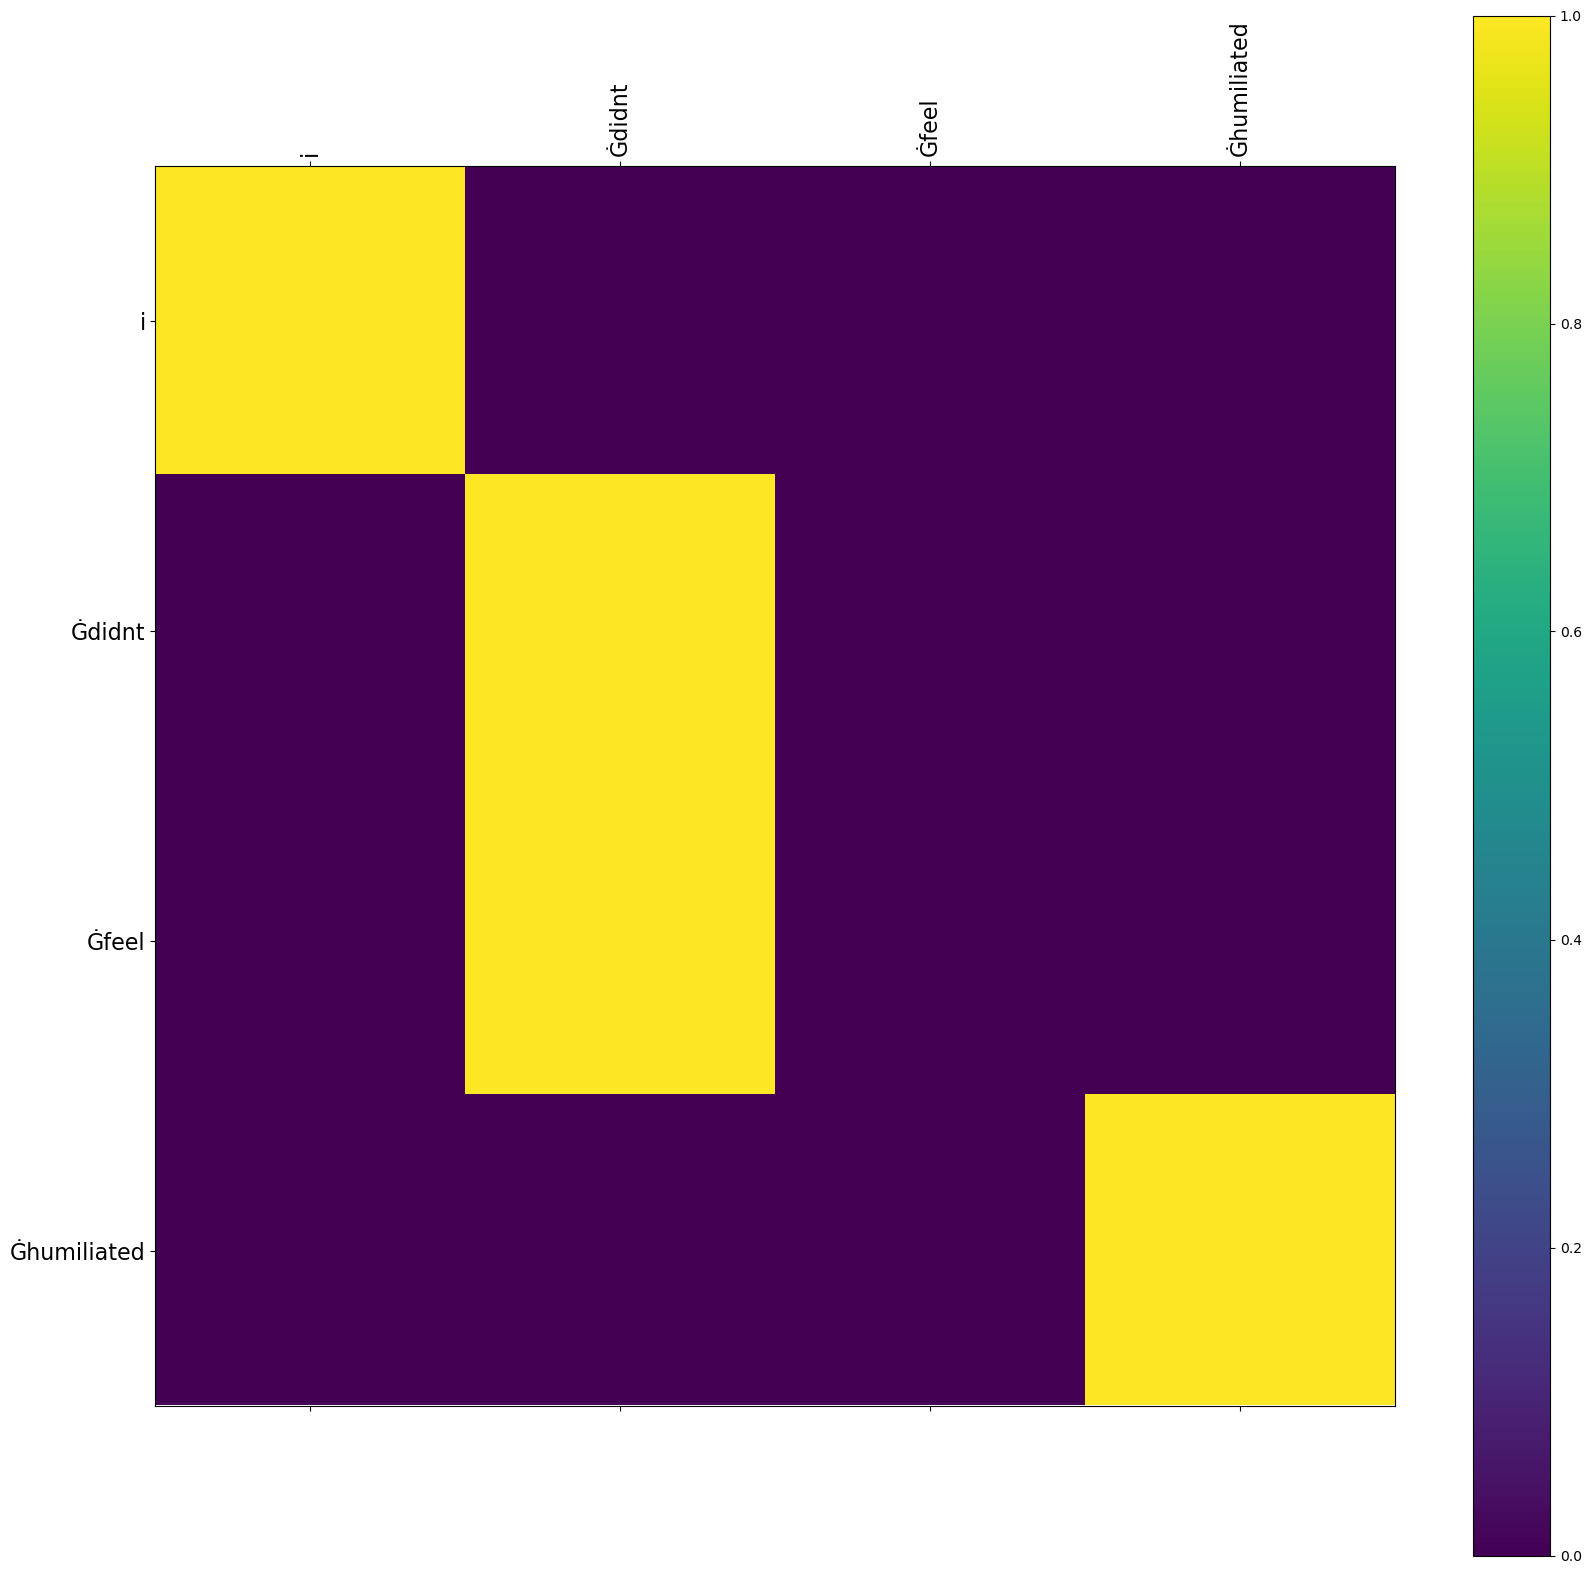

In [50]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [22]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [28]:
from tqdm.notebook import tqdm

num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        model_1.zero_grad()
        tokens = batch['input_ids'].squeeze().to(device)
        mask = batch['mask'].squeeze().to(device)
        target = batch['target'].squeeze().to(device)

        output = model_1(input_ids=tokens, attention_mask=mask)
        output = output['logits']

        loss = criterion(output, target)
        train_loss += loss
        
        loss.backward()
        optimizer.step()
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
                tokens = batch['input_ids'].squeeze().to(device)
                mask = batch['mask'].squeeze().to(device)
                target = batch['target'].squeeze().to(device)

                output = model_1(input_ids=tokens, attention_mask=mask)
                output = output['logits']

                valid_loss += criterion(output, target)

                acc = (output.argmax(dim=1)==target).sum().item()
                valid_acc += acc        
            
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch['input_ids'].squeeze().to(device)
        mask = batch['mask'].squeeze().to(device)
        target = batch['target'].squeeze().to(device)

        output = model_1(input_ids=tokens, attention_mask=mask)
        output = output['logits']    
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.35092949867248535,Valid Loss: 0.33146560192108154,Valid Acc: 55.75


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.30914416909217834,Valid Loss: 0.34595438838005066,Valid Acc: 55.125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.37467512488365173,Valid Loss: 0.5260734558105469,Valid Acc: 52.59375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5268969535827637,Valid Loss: 0.5563801527023315,Valid Acc: 51.65625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5143597722053528,Valid Loss: 0.6973669528961182,Valid Acc: 49.125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.41384434700012207,Valid Loss: 0.4736880660057068,Valid Acc: 53.875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.4403769373893738,Valid Loss: 0.6064444780349731,Valid Acc: 51.28125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.4062521755695343,Valid Loss: 0.5797921419143677,Valid Acc: 51.65625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.39239081740379333,Valid Loss: 0.5336802005767822,Valid Acc: 52.1875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.3285394608974457,Valid Loss: 0.5742431282997131,Valid Acc: 50.9375


IndexError: Dimension specified as -2 but tensor has no dimensions

Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [38]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [39]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [40]:
text = emotion_dataset["train"]["text"][0] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

In [41]:
attns = get_ettention_matrixes(model, tokenizer, text)
show_attention(seq, attn[-1][0])

NameError: name 'get_ettention_matrixes' is not defined

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >